# 6章 機械学習  
本章では，Fabio Gasparetti氏が公開しているNews Aggregator Data Setを用い，ニュース記事の見出しを「ビジネス」「科学技術」「エンターテイメント」「健康」のカテゴリに分類するタスク（カテゴリ分類）に取り組む．

## 50. データの入手・整形
>[News Aggregator Data Set](https://archive.ics.uci.edu/ml/datasets/News+Aggregator)をダウンロードし、以下の要領で学習データ（train.txt），検証データ（valid.txt），評価データ（test.txt）を作成せよ．  
 1. ダウンロードしたzipファイルを解凍し，readme.txtの説明を読む．
 2. 情報源（publisher）が”Reuters”, “Huffington Post”, “Businessweek”, “Contactmusic.com”, “Daily Mail”の事例（記事）のみを抽出する．
 3. 抽出された事例をランダムに並び替える．
 4. 抽出された事例の80%を学習データ，残りの10%ずつを検証データと評価データに分割し，それぞれtrain.txt，valid.txt，test.txtというファイル名で保存する．ファイルには，１行に１事例を書き出すこととし，カテゴリ名と記事見出しのタブ区切り形式とせよ（このファイルは後に問題70で再利用する）．  
 >
>学習データと評価データを作成したら，各カテゴリの事例数を確認せよ．

In [ ]:
# 指定のデータをダウンロード
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
!unzip NewsAggregatorDataset.zip

In [ ]:
# 確認
!head -10 ./newsCorpora.csv

1	Fed official says weak data caused by weather, should not slow taper	http://www.latimes.com/business/money/la-fi-mo-federal-reserve-plosser-stimulus-economy-20140310,0,1312750.story\?track=rss	Los Angeles Times	b	ddUyU0VZz0BRneMioxUPQVP6sIxvM	www.latimes.com	1394470370698
2	Fed's Charles Plosser sees high bar for change in pace of tapering	http://www.livemint.com/Politics/H2EvwJSK2VE6OF7iK1g3PP/Feds-Charles-Plosser-sees-high-bar-for-change-in-pace-of-ta.html	Livemint	b	ddUyU0VZz0BRneMioxUPQVP6sIxvM	www.livemint.com	1394470371207
3	US open: Stocks fall after Fed official hints at accelerated tapering	http://www.ifamagazine.com/news/us-open-stocks-fall-after-fed-official-hints-at-accelerated-tapering-294436	IFA Magazine	b	ddUyU0VZz0BRneMioxUPQVP6sIxvM	www.ifamagazine.com	1394470371550
4	Fed risks falling 'behind the curve', Charles Plosser says	http://www.ifamagazine.com/news/fed-risks-falling-behind-the-curve-charles-plosser-says-294430	IFA Magazine	b	ddUyU0VZz0BRneMioxUPQVP6sIxvM	www

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# データの読込
df = pd.read_csv('./newsCorpora.csv',sep='\t', usecols=[1,3,4], names=['TITLE', 'PUBLISHER', 'CATEGORY'])

# データの抽出
df = df.loc[df['PUBLISHER'].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']), ['TITLE', 'CATEGORY']]
# isisn()はbool型を返す
# つまり、ある値がデータフレームやシリーズの中に存在すれば「True」を返し、その値が存在しなければ「False」を返す
# loc[縦, 横]で任意の位置の値を取得。今回は特定のPUBLISHER(縦)のうちの、TITLEとCATEGORY(横)を取得。

# データの分割
train, valid_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=123, stratify=df['CATEGORY'])
valid, test = train_test_split(valid_test, test_size=0.5, shuffle=True, random_state=123, stratify=valid_test['CATEGORY'])
# train_test_split()にNumPy配列ndarrayを渡すと、二分割されたndarrayが要素として格納されたリストが返される。
# シャッフルされる場合、デフォルトでは実行するたびにランダムに分割される。引数random_stateを指定して乱数シードを固定すると常に同じように分割される。
# 　機械学習のモデルの性能を比較するような場合、どのように分割されるかによって結果が異なってしまうため、乱数シードを固定して常に同じように分割されるようにする必要がある
# 引数stratifyに均等に分割させたいデータ（多くの場合は正解ラベル）を指定すると、そのデータの値の比率が一致するように分割される。
# 　これにより、訓練データに正解のデータしかないというような偏りをなくすことが出来る。

## 51. 特徴量抽出

>学習データ，検証データ，評価データから特徴量を抽出し，それぞれtrain.feature.txt，valid.feature.txt，test.feature.txtというファイル名で保存せよ． なお，カテゴリ分類に有用そうな特徴量は各自で自由に設計せよ．記事の見出しを単語列に変換したものが最低限のベースラインとなるであろう

記事の見出しの単語群からTF-IDFを算出

In [ ]:
import string
import re

# 前処理
def preprocessing(text):
  # Plosser: → Plosser
  table = str.maketrans(string.punctuation, ' '*len(string.punctuation))  # 文字列変換テーブルの作成  # sting.punctuation：記号
   # maketrans(辞書)の形だと、１文字を任意の長さに変換できるが、maketrans(変換前, 変換後)だと１文字は１文字にしか変換できない 
  text = text.translate(table)  # 記号をスペースに置換
  
  text = text.lower()  # 小文字化
  text = re.sub('[0-9]+', '0', text)  # 数字列を0に置換

  return text

In [ ]:
# データの再結合
df = pd.concat([train, valid, test], axis=0)
df.reset_index(drop=True, inplace=True)  # indexを振りなおす
# 引数dropをTrueとすると、元のindexは削除され残らない
# デフォルトでは元のオブジェクトは変更されず、新たなオブジェクトが返されるが、引数inplaceをTrueとすると元のオブジェクトが変更される

# 前処理の実施
df['TITLE'] = df['TITLE'].map(lambda x: preprocessing(x))
# map関数では、リストなどの各要素に対して何かしらの変換を加えて別のオブジェクトを生成させることができる
# 第一引数に関数、第二引数にシーケンスを指定し、シーケンスの各要素に対して関数を適用する

print(df.head())

                                               TITLE CATEGORY
0  fitch lowers south africa credit rating outloo...        b
1  forex dollar rises on us rate speculation afte...        b
2  update 0 mexico s lower house generally approv...        b
3  u s  navy seals take control of north korean f...        b
4  beyonce   beyonce and jay z pay tribute to mic...        e


tf：Term Frequencyで，単語の出現頻度。文書dにおける単語wのtfは　wの出現数 / dの単語数 。「文書中により高頻度で出現する単語ほど，その文書にとって重要だ」という考え。  
idf：Inverse Document Frequencyで，逆文書頻度。文書群における単語wのidfは　log(文書数 / wが入っている文書数)　。「特定の文書に出現する単語ほど，ある話題に特化した意味のある単語である」という考え。  
tf-idf：上記２つの積

In [ ]:
# TfidfVectorizerは，文書群を与えると，各文書をtf-Idfの値を元にしたベクトルに変換するもの
# 入力は文字列のリストです．1つの文字列が1つの文書に相当します
# 出力は2次元の行列が返る。正確にはscipy(ｻｲﾊﾟｲ)のオブジェクトで，shapeは(文書数, 語彙サイズ)。各文書の存在する単語がTfidfに置き換わったリスト
# fit()メソッドで、入力の文書群を与えて，語彙の獲得やidfの計算
# transform()メソッドで、fit()したことで得た語彙やidfを元に，文書をtf-idf行列に変換。pythonのリストのように出力したい場合は，toarray()を使用
# fit_transform()は、fit()とtransform()を同時に行います．
# get_feature_names()は、特徴量ラベル（＝語彙）を表示します．transform()した後の行列では語彙サイズが列数になりますが，どの列がどの単語なのかを知る場合には，この関数を使います．

# min_df(①0~1,②整数)
  # 各単語において①使用されている文章の割合、または②使用されている文章数がパラメータ以下の単語を排除します。あまりにも使用されていない単語は排除するという考えです。

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer  # サイキットラーン

# データの分割
train_valid = df[:len(train) + len(valid)]
test = df[len(train) + len(valid):]

# TfidfVectorizer(インスタンス生成)
vec_tfidf = TfidfVectorizer(min_df=10)  # ngram_rangeでTF-IDFを計算する単語の長さを指定
                                                            # min_dfで特徴量の抽出数を制限。あまりに低い頻出度のものを除外？

# ベクトル化
X_train_valid = vec_tfidf.fit_transform(train_valid['TITLE'])  # testの情報は使わない(testデータ以外のデータから、語彙マップとidfを作成？(=学習))
# testの語彙を抜いてtrainとvalidの語彙だけで語彙マップを作るために、testを切り離した？
X_test = vec_tfidf.transform(test['TITLE'])  # テストデータで、モデルの語彙に基づくtf-idfを算出し、精度確認？(idfはモデルのを使用し、tfだけ新たに計算...？)

# ベクトルをデータフレームに変換
X_train_valid = pd.DataFrame(X_train_valid.toarray(), columns=vec_tfidf.get_feature_names())
X_test = pd.DataFrame(X_test.toarray(), columns=vec_tfidf.get_feature_names())

# データの分割
X_train = X_train_valid[:len(train)]
X_valid = X_train_valid[len(train):]


print(display(X_train))  # 縦：記事数　横：語彙リストに対する各記事中のtf-idf値

,0d,0m,0nd,0s,0st,0th,aa,abbvie,abc,about,above,abramson,abs,abuse,accelerates,access,accident,accord,account,accused,ackman,acquire,across,act,acting,action,activists,actor,actress,actually,ad,adam,adds,admits,ads,advance,advances,advice,aereo,affirms,...,woes,woman,women,won,woodley,woody,words,work,worker,workers,working,works,world,worries,worst,worth,would,wrapup,wren,wrong,wsj,wti,xbox,yahoo,year,years,yellen,yen,yet,yield,yields,york,you,young,your,yr,yuan,zac,zendaya,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.34156,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10669,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.324928,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10670,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.388372,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


None


## 52. 学習

>51で構築した学習データを用いて，ロジスティック回帰モデルを学習せよ．

回帰分析 (Regression)は、ある目的変数Yの値を、パラメーターθによって重み付けされた説明変数Xによって予測する方法

単回帰分析：1つの説明変数で1つの独立変数を求める  
　　　　　　ex. 未知の説明変数(経験)からでも目的変数(給料)の数値を見積もる  
重回帰分析：2つ以上の説明変数を用いて独立変数を求める  
ロジスティック回帰：縦軸が定量データではなく、ゼロかイチを判定する二値分類の問題を解く場合に用いられる(多クラス分類もできる)  
　　　　　　ex. ある商品のプロモーションにより購入されたか否か(Yes = 1 or No = 0)を年齢ごとに分類したデータから、新しいデータに対して商品を買う確率を計算する

In [ ]:
# 目的変数が値なら重回帰分析で、カテゴリ(数値化できないもの)ならロジスティック回帰？
# 今回は記事カテゴリ(bかhか...)を分類したいので、ロジスティック回帰

from sklearn.linear_model import LogisticRegression

# モデルの学習
model = LogisticRegression(random_state=123, max_iter=10000)
# random_state: 乱数生成器のシードを指定するパラメータ。数値（int型）かRandomStateインスタンスを指定する。モデルの再現性を担保するために、適当な値を指定しておいたほうがよい。


model.fit(X_train, train['CATEGORY'])
# fitメソッド：ロジスティック回帰モデルの重みを学習
# 説明変数：各語彙　独立変数：カテゴリー(e, b, t, m)

# 説明変数(語彙)の各値(特徴量)に重みをかける等で確率を導く。その重みを学習する。
# Nクラス分類の時は、重み行列Wのサイズはc(説明変数の数)×N(クラスの数)。説明変数ベクトルを行ベクトルXとすると、各クラスの確率はXとWの行列積の各列の値となる

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## 53. 予測

52で学習したロジスティック回帰モデルを用い，与えられた記事見出しからカテゴリとその予測確率を計算するプログラムを実装せよ．

In [ ]:
import numpy as np
# 最も高い確率の値とそのクラス名を返す
train_pred = [model.predict(X_train), np.max(model.predict_proba(X_train), axis=1)]
test_pred = [model.predict(X_test), np.max(model.predict_proba(X_test), axis=1)]
                                    # ↑各行で一番大きい値を取得
  # predict(X)：説明変数(入力X)の値からクラスラベルを予測
  # predict_proba(X)：各クラスの確率を予測

print("カテゴリ 確率")
for c, p in zip(train_pred[0][:5],train_pred[1][:5] ):
  print(c, p)

カテゴリ 確率
b 0.9522361586123828
b 0.9896971882323873
b 0.6405835893803277
b 0.5474147651494435
e 0.986168611930441


## 54. 正解率の計測

52で学習したロジスティック回帰モデルの正解率を，学習データおよび評価データ上で計測せよ．

In [ ]:
from sklearn.metrics import accuracy_score
# 正解率とは、分類したデータの総数のうち、正しく分類されたデータ数の割合
train_acc = accuracy_score(train['CATEGORY'], train_pred[0])  # train_pred[0] : 確率が最も高いクラス名
test_acc = accuracy_score(test['CATEGORY'], test_pred[0])
print(f'学習データ：{train_acc:.3f}')
print(f'評価データ：{test_acc:.3f}')

学習データ：0.920
評価データ：0.884


## 55. 混同行列の作成

52で学習したロジスティック回帰モデルの混同行列（confusion matrix）を，学習データおよび評価データ上で作成せよ．

　混同行列とは、実際のクラスが陰性(ex.病気じゃない),陽性(ex.病気である)のデータに対して、クラス陰,陽に分類されたデータの個数を要素とする行列です。
出力結果の

* 1行1列目の要素は、実際にクラス陰性で正しくクラス陰性に分類されたデータ数（真陰性（TN: True Negative））

* 1行2列目の要素は、実際には陰性だが誤って陽性に分類されたデータ数（偽陽性（FP: False Positive））

* 2行1列目の要素は、実際には陽性だが誤って陰性に分類されたデータ数（偽陰性（FN: False Negative））

* 2行2列目の要素は、実際に陽性で正しく陽性に分類されたデータ数（真陽性（TP: True Positive））
を表します。


In [ ]:
from sklearn.metrics import confusion_matrix

# 学習データ
train_cm = confusion_matrix(train['CATEGORY'], train_pred[0], labels=['b', 'e', 't', 'm'])  # 第一引数に実際のクラス（正解クラス）、第二引数に予測したクラスのリストや配列を指定する。
print(train_cm)                                                                             # confusion_matrixの引数のlabelsに順番を指定すると、混同行列の列と行がその順番に並ぶ    

[[4326  106   64    6]
 [  63 4147   11    2]
 [ 192  154  865    8]
 [  98  133   14  483]]


In [ ]:
# 評価データ
test_cm = confusion_matrix(test['CATEGORY'], test_pred[0])
print(test_cm)

[[529  23   2   9]
 [ 15 510   1   2]
 [ 13  33  40   5]
 [ 26  25   1 100]]


## 56. 適合率，再現率，F1スコアの計測

>52で学習したロジスティック回帰モデルの適合率，再現率，F1スコアを，評価データ上で計測せよ．カテゴリごとに適合率，再現率，F1スコアを求め，カテゴリごとの性能をマイクロ平均（micro-average）とマクロ平均（macro-average）で統合せよ．

　真陽性・偽陰性・偽陽性・真陰性の「真・偽」は「分類が当たっているか」を表し、「陽性・陰性」は「クラス1・クラス0」を表します。たとえば、偽陰性は、予測されたクラスは陰性だが分類が間違っていることを表します。
↓表で考えた方が分かりやすい

* 正解率(Accuracy)とは、分類したデータの総数のうち、正しく分類されたデータ数の割合です。式で書くと、(TP+TN)/(TP+FN+FP+TN)です。  
( 正しく認定 / 全体 )
(正しく認定されたものの割合)

* 適合率(Precision)とは、クラス1に分類されたデータのうち、実際にクラス1であるデータ数の割合です。式で書くと、TP/(TP+FP)です。正確性の指標。  
( 実際の陽性で正しく認定 / 陽性認定)
(陽性認定された中で正しく認定されたもの)

* 再現率(Recall)とは、実際にクラス1であるデータのうち、クラス1に分類されたデータ数の割合です。式で書くと、TP/(TP+FN)です。網羅性の指標。
( 陽性認定で正しく認定 / 実際の陽性 )
(実際の陽性の中で正しく認定されたもの)

* F1スコアは、適合率と再現率の調和平均で定義されます。一般に、適合率と再現率はトレードオフの関係にあるため、F1スコアはこれらのバランスを評価するための指標とみることができます。  
検索結果に含まれる文書が多くなれば再現率は当然上がりますが，その分不必要な文書も増える可能性があるので，適合率は下がる傾向にあります．

(N = 分類するクラス数, ni = そのクラスに分類された総数,xi = そのクラスに分類されたうち実際に正解だった数...と捉えると分かりやすい？)

マイクロ平均とは
**全クラスいっせい**(各クラスのTP, FP, FNをまとめる)に、平均したもの  
正解率の場合：Nセットのテストをする。iセット目のテストはni回のテストで構成されるとする。𝑛𝑖回のテストのうち，𝑥𝑖回が正解の場合，マイクロ平均は次式：
$\frac{\sum_{i=1}^{N} x_i}{\sum_{i=1}^{N} n_i}$  

マクロ平均とは
**クラスごと**にF1値を計算し(各クラスでTP, FP, FNを求める)にF1値を計算したもの  
正解率の場合：𝑛𝑖回のテストのうち，𝑥𝑖回が正解の場合，マクロ平均は次式：
$\frac{1}{N}\sum_{i=1}^{N}\frac{x_i}{n_i}$

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score


# 適合率
precision_each = list(precision_score(test['CATEGORY'], test_pred[0], average=None, labels=['b', 'e', 't', 'm'])) # average = Noneを指定するとクラスごとの精度をndarrayで返す。   
precision_micro = [precision_score(test['CATEGORY'],test_pred[0], average='micro')]  # マイクロ平均(全体の精度)
precision_macro = [precision_score(test['CATEGORY'],test_pred[0], average='macro')]  # マクロ平均(クラスごとの精度の平均)

precision = precision_each + precision_micro + precision_macro

# 再現率
recall_each = list(recall_score(test['CATEGORY'], test_pred[0], average=None, labels=['b', 'e', 't', 'm']))
recall_micro = [recall_score(test['CATEGORY'], test_pred[0], average='micro')]
recall_macro = [recall_score(test['CATEGORY'], test_pred[0], average='macro')]

recall = recall_each + recall_micro + recall_macro

# F1スコア
f1_each = list(f1_score(test['CATEGORY'], test_pred[0], average=None, labels=['b', 'e', 't', 'm']))
f1_micro = [f1_score(test['CATEGORY'], test_pred[0], average='micro')]
f1_macro = [f1_score(test['CATEGORY'], test_pred[0], average='macro')]

f1 = f1_each + f1_micro + f1_macro

scores = pd.DataFrame({'適合率': precision, '再現率': recall, 'F1スコア': f1},  # 列名
                      index=['b', 'e', 't', 'm', 'マイクロ平均', 'マクロ平均'])  # 行名
# 例えば、precisionの１列目は、b, e, t, mの適合率、そのマイクロ平均、そのマクロ平均が縦に並ぶ

display(scores)

,適合率,再現率,F1スコア
b,0.907376,0.939609,0.923211
e,0.862944,0.965909,0.911528
t,0.862069,0.657895,0.746269
m,0.909091,0.439560,0.592593
マイクロ平均,0.883808,0.883808,0.883808
マクロ平均,0.885370,0.750743,0.793400


## 57. 特徴量の重みの確認

52で学習したロジスティック回帰モデルの中で，重みの高い特徴量トップ10と，重みの低い特徴量トップ10を確認せよ．

In [ ]:
# X_train : tf-idfを算出したもの(行：文書番号  列：各語彙のtf-idf値)(DataFrame型)
for class_, weight in zip(model.classes_, model.coef_):  # classes_:クラス名のリスト  # coef_: 学習した各特徴量の重みは、クラスごとに(１つのリストで?)coef_に格納
  print(class_)
  best10 = pd.DataFrame(X_train.columns.values[np.argsort(weight)[::-1][:10]], columns=['上位10位'], index=range(1, 11)).T
    # .columnsで列名取得。インデックスオブジェクトではなくリストにしたい場合は.columns.values
  # np.argsort()は値ではなく並び替えたインデックス（元のndarrayでの位置 = 0始まりの順番）のndarrayを返す。
    # np.sort()関数にはPython標準のsort()メソッドやsorted()関数のように引数reverseは存在しない。降順(大きい順)にしたい場合はスライス[::-1]を使う。

  worst10 = pd.DataFrame(X_train.columns.values[np.argsort(weight)[:10]], columns=['下位10位'], index=range(1, 11)).T
  display(pd.concat([best10, worst10], axis=0))
  print('\n')


b


,1,2,3,4,5,6,7,8,9,10
上位10位,bank,fed,stocks,china,ecb,ukraine,obamacare,euro,oil,yellen
下位10位,her,ebola,video,she,the,aereo,and,virus,microsoft,google




e


,1,2,3,4,5,6,7,8,9,10
上位10位,kardashian,chris,star,miley,she,movie,thrones,paul,he,kim
下位10位,us,google,update,study,gm,china,facebook,billion,ceo,could




m


,1,2,3,4,5,6,7,8,9,10
上位10位,ebola,study,fda,drug,cancer,mers,cases,could,cigarettes,health
下位10位,facebook,gm,bank,apple,ceo,google,game,climate,twitter,deal




t


,1,2,3,4,5,6,7,8,9,10
上位10位,google,facebook,apple,microsoft,climate,gm,tesla,nasa,earth,heartbleed
下位10位,stocks,fed,her,percent,american,drug,shares,cancer,ukraine,still


##58. 正則化パラメータの変更

>ロジスティック回帰モデルを学習するとき，正則化パラメータを調整することで，学習時の過学習（overfitting）の度合いを制御できる．異なる正則化パラメータでロジスティック回帰モデルを学習し，学習データ，検証データ，および評価データ上の正解率を求めよ．実験の結果は，正則化パラメータを横軸，正解率を縦軸としたグラフにまとめよ．

正則化 (Regularization)とは、過学習を防いで汎化性能（未知のデータへの対応能力）を高めるためのテクニックの一つで、モデルに「正則化項」というものを付けることでモデルの形が複雑になりすぎないように調整しようとするもの。パラメーターの値を十分小さくしてしまえば、説明変数がどんな多項式であっても、その説明変数の予測値への影響を小さくできるからオーバーフィットしにくくなる、という考えです。


L1の正則化は、wの数値の多くが0になるようにし、次元圧縮を行います。
L2の正則化は、wの数値をできるだけ0に近づけていこうという方向性でモデルの複雑化を防ごうとします。

scikit-learnのロジスティック回帰には、デフォルトでL2という正則化が行われています。

In [ ]:
result = []
# 10^-5～10^4まで作成
for C in np.logspace(-5, 4, 10, base=10):  # numpy.logspaceで対数スケールの配列を生成できます。
                                                 # numpy.logspace(start, stop, num=50, base=10.0)
                                                 #             (最初の値, 最後の値, 生成する配列の要素数, 底)
  # モデルの学習
  model = LogisticRegression(random_state=123, max_iter=10000, C=C)
    # Cは正則化の強さを指定するパラメータ。正の値を指定する（デフォルト値は1.0）。Cの値が小さいほど正則化の強さが増す。
    # Cを変えて学習結果を比較
  model.fit(X_train, train['CATEGORY'])

  # 予測値の取得
  train_pred = model.predict(X_train)
  valid_pred = model.predict(X_valid)
  test_pred = model.predict(X_test)

  # 正解率の算出
  train_acc = accuracy_score(train['CATEGORY'], train_pred )
  valid_acc = accuracy_score(valid['CATEGORY'], valid_pred )
  test_acc = accuracy_score(test['CATEGORY'], test_pred )

  # 結果の格納
  result.append([C, train_acc, valid_acc, test_acc])  # リストの要素にリストを格納することで二次元配列構造を実現できる。
                                                                     # リスト自体は次元の概念が無い？

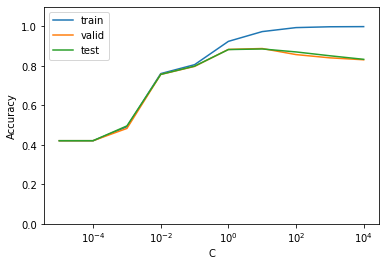

In [ ]:
# 視覚化
result = np.array(result).T  # でもリストinリストしたものを転置させると、行列の転置と同じ挙動をする
                             # これにより、Cだけでまとまったリスト・train_accuracyだけでまとまったリスト...が作れる！
plt.plot(result[0], result[1], label='train')
plt.plot(result[0], result[2], label='valid')
plt.plot(result[0], result[3], label='test')
plt.ylim(0, 1.1)
plt.ylabel('Accuracy')
plt.xscale ('log')
plt.xlabel('C')
plt.legend()
plt.show()


##59. ハイパーパラメータの探索

学習アルゴリズムや学習パラメータを変えながら，カテゴリ分類モデルを学習せよ．検証データ上の正解率が最も高くなる学習アルゴリズム・パラメータを求めよ．また，その学習アルゴリズム・パラメータを用いたときの評価データ上の正解率を求めよ．

In [ ]:
# Optuna(オプチュナ)はハイパーパラメータの最適化を自動化するためのソフトウェアフレームワーク
!pip install optuna

　ハイパーパラメータとは、機械学習アルゴリズムの挙動を制御するパラメータのことです。特に深層学習では勾配法によって最適化できない・しないパラメータに相当します。例えば、学習率やバッチサイズ、学習イテレーション数といったようなものがハイパーパラメータとなります。また、ニューラルネットワークの層数やチャンネル数といったようなものもハイパーパラメータです。

In [ ]:
import optuna

# 最適化対象を関数で指定
def objective(trial): # trialは後々使われるOptunaに実装されているクラスのインスタンスです。適当な範囲から値をサンプリングしてくる役割
  # チューニング対象パラメータのセット
  # 今回は l1_ratio と C の値を変える
  l1_ratio = trial.suggest_uniform('l1_ratio', 0, 1)  # l1_ratioという変数名で、[0, 1]の範囲の一様分布から値を取る
  C = trial.suggest_loguniform('C', 1e-4, 1e4)  # 対数(log)領域で値を取る

  # モデルの学習
  # Elastic Netは一般化線形モデルの回帰に正則化項を加味するモデル。メリットとして次元削除と過学習防止を良い塩梅にやってくれるらしい。
  model = LogisticRegression(random_state=123, 
                          max_iter=10000, 
                          penalty='elasticnet',   # 正則化の方法。L1, L2両方使う
                          solver='saga',   # 最適化の方法. For multiclass problems
                          l1_ratio=l1_ratio,  # L1正則化とL2正則化のバランスを指定
                          C=C)
  model.fit(X_train, train['CATEGORY'])

  # 予測値の取得
  valid_pred = model.predict(X_valid)

  # 正解率の算出
  valid_accuracy = accuracy_score(valid['CATEGORY'], valid_pred)    

  return valid_accuracy 

In [ ]:
# 最適化
# 最適化を開始するには、Studyを作成し、目的関数をoptimize()に渡します。n_trialsは試行回数です。
# たった上記のコードだけで「目的関数に値をランダムに入れてみて、最大値を見つける」というプログラムの完成です。
# studyオブジェクトには最適化の結果が内部変数として保持されています。

study = optuna.create_study(direction='maximize')
study.optimize(objective, timeout=3600)

# 結果の表示
print('Best trial:')
trial = study.best_trial # study.best_valueは今回の実験で得られた目的関数の最大値
print('  Value: {:.3f}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():  # study.best_paramsはその時のハイパーパラメータの値。仮に多変数関数の最小・最大化を行った場合には、幾つかの変数を同時に扱うことになるので、study_paramsは各変数の名前と値を辞書で持ってくれています。便利ですね。
  print('    {}: {}'.format(key, value))

[I 2021-06-04 08:15:34,245] A new study created in memory with name: no-name-4dd3184b-b379-49e1-b965-2d4f8c286b55
[I 2021-06-04 08:15:35,144] Trial 0 finished with value: 0.42128935532233885 and parameters: {'l1_ratio': 0.98972555975793, 'C': 0.0002912832225830733}. Best is trial 0 with value: 0.42128935532233885.
[I 2021-06-04 08:15:39,278] Trial 1 finished with value: 0.42128935532233885 and parameters: {'l1_ratio': 0.5307153488109865, 'C': 0.0016681367798321832}. Best is trial 0 with value: 0.42128935532233885.
[I 2021-06-04 08:28:16,701] Trial 2 finished with value: 0.8545727136431784 and parameters: {'l1_ratio': 0.6800830548968886, 'C': 146.11830790276045}. Best is trial 2 with value: 0.8545727136431784.
[I 2021-06-04 08:45:50,704] Trial 3 finished with value: 0.8508245877061469 and parameters: {'l1_ratio': 0.4870964547522324, 'C': 549.1174534666801}. Best is trial 2 with value: 0.8545727136431784.
[I 2021-06-04 08:45:56,394] Trial 4 finished with value: 0.42128935532233885 and pa

Best trial:
  Value: 0.877
  Params: 
    l1_ratio: 0.0642747488127583
    C: 38.071530393006654
